<a href="https://colab.research.google.com/github/Sankarlalr23/Automotive_Telematics_Analytics/blob/main/anomaly_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
plt.rcParams.update({'font.size': 14})

from collections import Counter

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
 
train_path='/content/drive/My Drive/Xen.AI'

data_all = pd.read_csv('/content/drive/My Drive/Xen.AI/telematics_data.csv')   # data importing

Mounted at /content/drive/


In [3]:
data_all.head()

,year,month,day,vin,wmi,engine_cd,device_type,msg_ts,vin_utc_key,packet_id,reason_code,script_version,deviceid,latitude,longitude,driveridcode1,obdvin,vehiclebattvolts,fuel_total,engine_rpm,coolant_tmp,fuel_lvl_pct,driving_tme_sec,cruise_tme_sec,idle_tme_sec,idle_fuel_total,pto_tme_total,pto_fuel_total,gear,fuel_tmp,oil_tmpl,throt_pos,mpg,acel_pos,engine_pct_load,torque,oil_lvl,oil_psi,coolant_psi,intak_air_tmp,manifold_tmp,vehiclespeed,heading,odometerinmeters,odometer
0,2020,4,18,3HSDZTZR9KN352697,3HS,TZ,Xirgo,2020-04-18 06:50:40,3HSDZTZR9KN3526972020-04-18 06:50:40,36,9,204.0,173101817,38.799149,-90.603680,0.0,3HSDZTZR9KN352697,14.2,106165.0,1144.0,79.0,41.0,NaN,NaN,2167380.0,1503.0,0.0,0.0,1.0,0.0,76.0,0.0,NaN,0.0,11.0,12.0,0.0,340.0,0.0,4.0,10.0,1005.0,960.0,380663000.0,380663.0
1,2020,5,20,3HSDZTZR9LN055320,3HS,TZ,Xirgo,2020-05-20 03:01:09,3HSDZTZR9LN0553202020-05-20 03:01:09,36,9,204.0,172301945,33.618963,-84.333847,0.0,3HSDZTZR9LN055320,NaN,NaN,584.0,61.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0,0.0,56.0,1.0,NaN,0.0,26.0,11.0,0.0,228.0,0.0,24.0,NaN,11.0,700.0,88781990.0,NaN
2,2020,4,1,3HSDZTZR0KN354211,3HS,TZ,Xirgo,2020-04-01 20:02:39,3HSDZTZR0KN3542112020-04-01 20:02:39,36,9,204.0,173511306,41.139005,-101.173123,0.0,3HSDZTZR0KN354211,NaN,113134.0,1145.0,81.0,NaN,NaN,NaN,1788120.0,1172.0,NaN,0.0,1.0,0.0,NaN,0.0,NaN,NaN,41.0,42.0,NaN,320.0,0.0,25.0,NaN,NaN,2709.0,416436440.0,NaN
3,2020,5,5,3HSDWTZR8LN845362,3HS,TZ,Xirgo,2020-05-05 06:17:36,3HSDWTZR8LN8453622020-05-05 06:17:36,36,9,204.0,173404340,38.856184,-98.139251,0.0,3HSDWTZR8LN845362,14.0,149410.0,1368.0,81.0,54.0,NaN,NaN,786600.0,497.0,0.0,0.0,1.0,0.0,86.0,0.0,NaN,0.0,19.0,19.0,0.0,424.0,0.0,13.0,30.0,1095.0,838.0,426460520.0,NaN
4,2020,4,7,3HSDZTZRXLN085409,3HS,TZ,N2,2020-04-07 20:14:07,3HSDZTZRXLN0854092020-04-07 20:14:07,36,9,204.0,190815-0009,33.351086,-87.017387,0.0,3HSDZTZRXLN085409,14.1,33886.0,1167.0,82.0,NaN,4755420.0,NaN,NaN,504.0,0.0,0.0,1.0,NaN,88.0,0.0,NaN,NaN,65.0,67.0,NaN,320.0,NaN,NaN,NaN,1090.0,458.0,107975440.0,NaN


In [4]:
data_all['month'].value_counts()

4    299339
5    215655
Name: month, dtype: int64

In [5]:
data_all['utctime'] = data_all['msg_ts']

## Anomaly class

In [6]:
!pip install pyod

!pip install --upgrade pyod  # to make sure that the latest version is installed!

     |████████████████████████████████| 112kB 8.3MB/s 
  Created wheel for pyod: filename=pyod-0.8.9-cp37-none-any.whl size=121413 sha256=a8e888befdd72826c1d355324f4c03450f36074120bcada628705830400e0757
  Stored in directory: /root/.cache/pip/wheels/9b/31/18/f12932b880f1ce4c181cbe51454ddaaa02665ad7cfc663f639
Successfully built pyod
Requirement already up-to-date: pyod in /usr/local/lib/python3.7/dist-packages (0.8.9)


In [7]:
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
from pyod.models.loda import LODA

def get_threshold(scores, n_std=2):
    return np.mean(scores) + n_std*np.std(scores)
    
class Anomaly(object):
    def __init__(self, variables, data):
        self.variables = variables
        self.data_train = data
        
        #Initialize scaler
        self.scaler = preprocessing.MinMaxScaler()
        
        #Algorithm initializations
        self.knn = KNN(n_neighbors=10) 
        self.iforest = IForest()
        self.loda = LODA(n_bins=20, n_random_cuts=200)
        
        #Anomaly thresholds
        self.knn_thr = -1000.
        self.iforest_thr = -1000.
        self.loda_thr = -1000.
        
    def preprocess(self, data, train=False):
        # drop NANs
        dataset = data.drop(['vin','utctime'], axis=1)[self.variables].dropna()
        #dataset = data.dropna(subset=[self.variables])
        #vins = dataset.vin.values
        # scale data
        if train:
            data_scaled = self.scaler.fit_transform(dataset[self.variables])
        else:
            data_scaled = self.scaler.transform(dataset[self.variables])
        X = pd.DataFrame(data_scaled, columns=dataset.columns,index=dataset.index)
        
        return X
        
    def train(self):
        self.X_train = self.preprocess(self.data_train, True)
        self.knn.fit(self.X_train)
        self.iforest.fit(self.X_train)
        self.loda.fit(self.X_train)

    def calc_scores(self, data_test, train=False):
        
        if train:
            X_test = self.X_train
        else:
            X_test = self.preprocess(data_test, train)
        
        #calculate algorithm scores:
        knn_scores = self.knn.decision_function(X_test)
        iforest_scores = self.iforest.decision_function(X_test)
        loda_scores = self.loda.decision_function(X_test)
        
        #calculate threshold
        if train:
            self.knn_thr = get_threshold(knn_scores)
            self.iforest_thr = get_threshold(iforest_scores)
            self.loda_thr = get_threshold(loda_scores)
    
        #determine anomaly
        if self.knn_thr < -999:
            print('\nWarning: KNN anomaly score is not determined yet!\n')
        
        X_test.loc[:,'as_knn'] = knn_scores
        X_test.loc[:,'as_iforest'] = iforest_scores
        X_test.loc[:,'as_loda'] = loda_scores
        X_test['anomaly_knn'] = X_test['as_knn'] > self.knn_thr
        X_test['anomaly_iforest'] = X_test['as_iforest'] > self.iforest_thr
        X_test['anomaly_loda'] = X_test['as_loda'] > self.loda_thr
        
        X_test.loc[:,'vin'] = data_test.vin.values
        
        return X_test
    
    def get_anomaly_frac(self, df, daily=True, plot=False, nmax=20):
        df['day']  = [str(x)[:10] for x in df.index]
        df['hour'] = [str(x)[:13] for x in df.index]

        agg = 'day'
        if not daily:
            agg = 'hour'
            
        def get_f(algo, anomaly):
            t = df.groupby(['vin',agg]).apply(lambda tmp: len(tmp.query(anomaly)) / len(tmp))
            return t.to_frame().reset_index().rename(columns={0:f'frac_{algo}'})
        t1 = get_f('KNN','anomaly_knn')
        t2 = get_f('IForest','anomaly_iforest')
        t3 = get_f('LODA','anomaly_loda')
        t = pd.merge(t1,t2, on=['vin',agg])
        t = pd.merge(t,t3, on=['vin',agg])
        
        return t


In [8]:
v = ['fuel_total', 'engine_rpm', 'coolant_tmp', 'oil_tmpl','throt_pos', 'torque', 'oil_psi', 'manifold_tmp', 'vehiclespeed',
       'odometerinmeters']

data_all.index = pd.to_datetime(data_all.utctime, format='%Y-%m-%d %H:%M:%S')
data_all = data_all.sort_index()

data_all_sel = data_all.dropna(subset=v)

#data_train = data_all['2021-02-01 00:00:00':'2021-02-25 00:00:01']

data_train = data_all_sel['2020-04-01 00:00:00':'2020-05-20 00:00:01']
data_test = data_all_sel['2020-05-20 00:00:01':]

In [9]:
data_train.head()

,year,month,day,vin,wmi,engine_cd,device_type,msg_ts,vin_utc_key,packet_id,reason_code,script_version,deviceid,latitude,longitude,driveridcode1,obdvin,vehiclebattvolts,fuel_total,engine_rpm,coolant_tmp,fuel_lvl_pct,driving_tme_sec,cruise_tme_sec,idle_tme_sec,idle_fuel_total,pto_tme_total,pto_fuel_total,gear,fuel_tmp,oil_tmpl,throt_pos,mpg,acel_pos,engine_pct_load,torque,oil_lvl,oil_psi,coolant_psi,intak_air_tmp,manifold_tmp,vehiclespeed,heading,odometerinmeters,odometer,utctime
utctime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-04-01 00:00:07,2020,4,1,3HSDZTZR4KN126504,3HS,TZ,Xirgo,2020-04-01 00:00:07,3HSDZTZR4KN1265042020-04-01 00:00:07,36,9,204.0,173100734,38.104358,-81.383771,0.0,3HSDZTZR4KN126504,14.2,107014.0,988.0,79.0,48.0,NaN,NaN,1974600.0,NaN,NaN,0.0,1.0,0.0,81.0,0.0,NaN,0.0,32.0,32.0,0.0,296.0,0.0,9.0,15.0,868.0,3184.0,398385440.0,NaN,2020-04-01 00:00:07
2020-04-01 00:00:19,2020,4,1,3HSDZTZR5LN134290,3HS,TZ,Xirgo,2020-04-01 00:00:19,3HSDZTZR5LN1342902020-04-01 00:00:19,36,9,204.0,173406713,34.871776,-114.818512,0.0,3HSDZTZR5LN134290,14.1,83536.0,1489.0,84.0,NaN,NaN,NaN,6223500.0,4295.0,0.0,0.0,1.0,0.0,94.0,0.0,NaN,0.0,0.0,0.0,0.0,452.0,0.0,28.0,43.0,1106.0,693.0,265633380.0,NaN,2020-04-01 00:00:19
2020-04-01 00:00:32,2020,4,1,3HSDWTZR7LN064378,3HS,TZ,Xirgo,2020-04-01 00:00:32,3HSDWTZR7LN0643782020-04-01 00:00:32,36,9,204.0,172302416,41.665867,-71.938993,0.0,3HSDWTZR7LN064378,NaN,61752.0,599.0,49.0,100.0,NaN,NaN,2240640.0,1519.0,0.0,NaN,3.0,0.0,43.0,0.0,NaN,0.0,13.0,6.0,0.0,268.0,0.0,10.0,18.0,0.0,NaN,194690940.0,NaN,2020-04-01 00:00:32
2020-04-01 00:01:06,2020,4,1,3HSDWTZR5LN844783,3HS,TZ,Xirgo,2020-04-01 00:01:06,3HSDWTZR5LN8447832020-04-01 00:01:06,36,9,204.0,173405767,39.490648,-84.324529,0.0,3HSDWTZR5LN844783,14.1,19870.0,1376.0,81.0,99.0,NaN,NaN,NaN,135.0,0.0,NaN,1.0,0.0,83.0,100.0,NaN,0.0,16.0,16.0,0.0,388.0,0.0,10.0,32.0,1094.0,1834.0,284931580.0,NaN,2020-04-01 00:01:06
2020-04-01 00:02:21,2020,4,1,3HSDZTZR5LN134290,3HS,TZ,Xirgo,2020-04-01 00:02:21,3HSDZTZR5LN1342902020-04-01 00:02:21,36,9,204.0,173406713,34.882584,-114.781823,0.0,3HSDZTZR5LN134290,14.1,83536.0,1462.0,82.0,59.0,NaN,NaN,6223500.0,4295.0,0.0,0.0,1.0,0.0,91.0,0.0,NaN,0.0,0.0,0.0,0.0,380.0,0.0,27.0,39.0,1038.0,894.0,265636940.0,NaN,2020-04-01 00:02:21


In [10]:
#instantiate
a = Anomaly(v, data_train)

In [11]:
#train algos
a.train()

In [12]:
#calc scores for train
X_train = a.calc_scores(data_train, True)

In [13]:
X_train.head()

,fuel_total,engine_rpm,coolant_tmp,oil_tmpl,throt_pos,torque,oil_psi,manifold_tmp,vehiclespeed,odometerinmeters,as_knn,as_iforest,as_loda,anomaly_knn,anomaly_iforest,anomaly_loda,vin
utctime,,,,,,,,,,,,,,,,,
2020-04-01 00:00:07,0.427126,0.068537,0.832168,0.914729,0.0,0.685590,0.323144,0.266667,0.604036,0.668738,0.084873,-0.047788,0.012859,False,False,False,3HSDZTZR4KN126504
2020-04-01 00:00:19,0.333417,0.133325,0.867133,0.948320,0.0,0.545852,0.493450,0.577778,0.769659,0.445897,0.063140,-0.061243,0.012335,False,False,False,3HSDZTZR5LN134290
2020-04-01 00:00:32,0.246470,0.018234,0.622378,0.816537,0.0,0.572052,0.292576,0.300000,0.000000,0.326812,0.045028,0.063145,0.014733,False,True,False,3HSDWTZR7LN064378
2020-04-01 00:01:06,0.079304,0.118712,0.846154,0.919897,1.0,0.615721,0.423581,0.455556,0.761308,0.478292,0.046159,-0.061552,0.013195,False,False,False,3HSDWTZR5LN844783
2020-04-01 00:02:21,0.333417,0.129833,0.853147,0.940568,0.0,0.545852,0.414847,0.533333,0.722338,0.445903,0.049771,-0.107635,0.011531,False,False,False,3HSDZTZR5LN134290


In [14]:
a.knn_thr, a.iforest_thr, a.loda_thr

(0.11722372170473133, 0.03697761977021241, 0.01638862258459863)

In [15]:
#calc scores for test sample
X_test = a.calc_scores(data_test)

In [16]:
#get anomaly frac on test sample
xt_frac = a.get_anomaly_frac(X_test, True)

In [17]:
xt_frac.head()

,vin,day,frac_KNN,frac_IForest,frac_LODA
0,1HSERTZRXLH809470,2020-05-20,0.000000,0.000000,0.000000
1,1HSERTZRXLH809470,2020-05-21,0.000000,0.000000,0.000000
2,1HSERTZRXLH809470,2020-05-22,0.000000,0.098361,0.098361
3,1HSERTZRXLH809470,2020-05-23,0.119048,0.119048,0.190476
4,1HSERTZRXLH809470,2020-05-24,0.285714,0.476190,0.523810


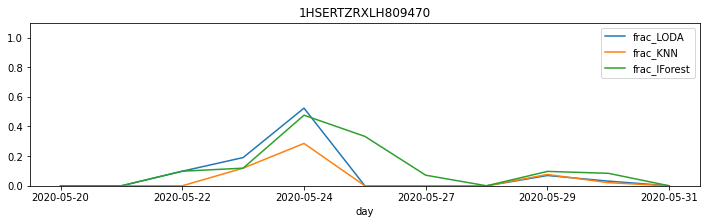

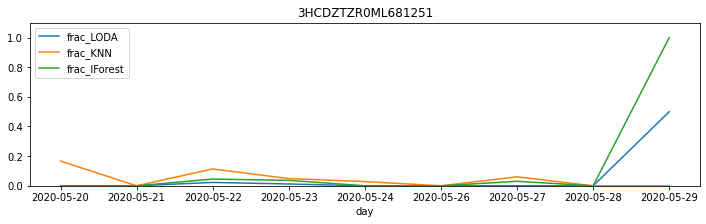

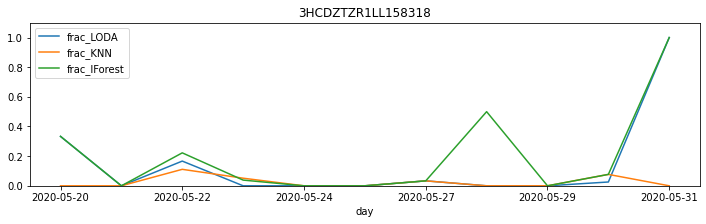

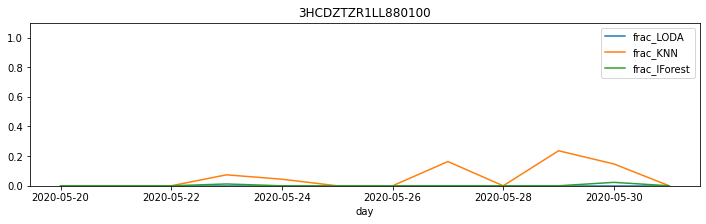

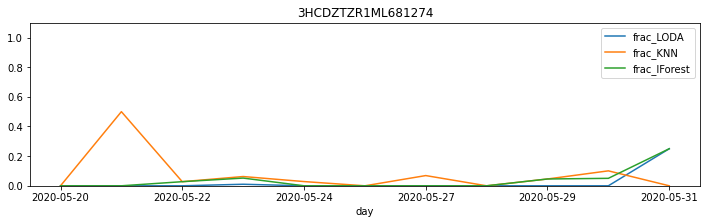

In [18]:
n = 0
nmax = 5
for vin, tv in xt_frac.groupby('vin'):
    if n < nmax and len(tv)>1:
        tv.index = tv.day
        tv[['frac_LODA','frac_KNN','frac_IForest']].plot(subplots=False, legend=True, logy=False, figsize = (12,3), 
                                ylim=(0,1.1),title=vin)
    n += 1